## **Building, Tuning and Evaluating a standard RNN Model for NLP**

### **Libraries**

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset

### **Utility Function**

In [ ]:
def regularized_f1(train_f1, dev_f1, threshold=0.0015):
    """
    Returns development F1 if overfitting is below threshold, otherwise 0.
    """
    return dev_f1 if (train_f1 - dev_f1) < threshold else 0


def save_metrics(*args, path, fname):
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.isfile(path + fname):
        with open(path + fname, "w", newline="\n") as f:
            f.write(
                ",".join(
                    [
                        "config",
                        "epoch",
                        "train_loss",
                        "train_acc",
                        "train_f1",
                        "val_loss",
                        "val_acc",
                        "val_f1",
                    ]
                )
            )
            f.write("\n")
    if args:
        with open(path + fname, "a", newline="\n") as f:
            f.write(",".join([str(arg) for arg in args]))
            f.write("\n")


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

### **Constants**

In [ ]:
VOCAB_SIZE = 20_000
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LEN = 256
LEARNING_RATE = 1e-4

### **Step 1 - Download and prepare the dataset**

I loaded the IMDB dataset using the datasets module from Hugging Face, which conveniently includes preprocessed train and test splits.
Next, I customized the train/validation split to better control the distribution of samples during training and evaluation. Specifically:

- I selected the central portion of the original training set (from 10% to 85%) to serve as the actual training data.

- The remaining outer segments (the first 10% and the last 15%) were combined and used as the validation set.

This slicing strategy allowed me to simulate a more realistic validation scenario while maintaining a balanced and representative training set. I used the Hugging Face slicing API directly within the load_dataset function to perform this operation efficiently.

The test set provided by the original IMDB dataset remained unchanged and was reserved for final evaluation.

In [ ]:
# load dataset in splits
train_data = load_dataset("imdb", split="train[10%:85%]")
dev_data = load_dataset("imdb", split="train[:10%]+train[85%:]")
test_data = load_dataset("imdb", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

I defined a tokenizer using `get_tokenizer` with the `'spacy'` backend (`en_core_web_sm`), then built the vocabulary from the dataset using `build_vocab_from_iterator`. I included the special tokens `'<UNK>'` at index `0` and `'<PAD>'` at index `1`, limited the vocabulary size to `VOCAB_SIZE`, and set `'<UNK>'` as the default index for unknown tokens. I also added a test to verify that unknown tokens correctly return index `0`.


In [ ]:
# define tokenizer
tokenizer = get_tokenizer("spacy")  # using spaCy tokenizer


# function to generate and yield the tokens from the dataset
def yield_tokens(data):
    for text in data:
        yield tokenizer(text["text"])


# define vocabulary
vocab = build_vocab_from_iterator(
    yield_tokens(train_data),
    specials=["<UNK>", "PAD"],
    max_tokens=VOCAB_SIZE,
)

# set the special tokens
vocab.set_default_index(vocab["<UNK>"])

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


I used the tokenizer and vocabulary to convert the three data splits into sequences of token indices, applying a maximum sequence length of `MAX_LEN`. While this preprocessing was done ahead of time here, it's typically performed on the fly within the `DataLoader`'s `collate_batch` function to handle memory constraints efficiently.

In [ ]:
train_idx = [
    torch.tensor(vocab(tokenizer(text["text"]))[:MAX_LEN]) for text in train_data
]
dev_idx = [torch.tensor(vocab(tokenizer(text["text"]))[:MAX_LEN]) for text in dev_data]
test_idx = [
    torch.tensor(vocab(tokenizer(text["text"]))[:MAX_LEN]) for text in test_data
]

I defined a custom PyTorch dataset by subclassing Dataset, implementing the logic to return tokenized indices and corresponding labels for each sample. I then instantiated this dataset to prepare it for use in the data loading pipeline.

with this line we create a dataset which is simple to work on it 

In [ ]:
class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
        self.sequences = seq
        self.labels = lbl

    def __getitem__(self, idx):
        return {"input_ids": self.sequences[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.sequences)

In [ ]:
train_set = ImdbDataset(train_idx, train_data["label"])
dev_set = ImdbDataset(dev_idx, dev_data["label"])
test_set = ImdbDataset(test_idx, test_data["label"])

- I implemented a custom GroupedSampler to improve training efficiency by grouping samples of similar length, reducing padding variability within batches. 

- In the __init__ method, I paired each dataset index with the length of its tokenized sequence.

- In the __iter__ method, I shuffled this list, formed temporary groups of size BATCH_SIZE * 100, and sorted each group by sequence length to preserve input diversity across epochs.
I then extracted only the sorted indices and returned them as an iterator. Finally, 

- I completed the __len__ method to return the total number of samples.

In [ ]:
class GroupedSampler(Sampler):
    def __init__(self, seqs, batch_size):
        """
        Args:
            seqs (List[List[int]]): List of tokenized sequences from ImdbDataset.
            batch_size (int): Batch size for sampling.
        """
        self.seqs = seqs
        self.batch_size = batch_size

        # pair each sequence index with its tokenized sequence length
        self.index_length_list = [(index, len(seq)) for index, seq in enumerate(seqs)]

    def __iter__(self):
        # shuffle the index-length list for randomness each epoch
        random.shuffle(self.index_length_list)

        # chunk size as per specifications
        chunk_size = self.batch_size * 100
        grouped_indices = []

        # process in chunks, sort each chunk by sequence length
        for i in range(0, len(self.index_length_list), chunk_size):
            chunk = self.index_length_list[i : i + chunk_size]

            # sort within the chunk by sequence length
            chunk.sort(key=lambda x: x[1])  # sort by sequence length (ascending)

            # extend grouped_indices with only the indices from each sorted chunk
            grouped_indices.extend([index for index, _ in chunk])

        return iter(grouped_indices)

    def __len__(self):
        return len(self.seqs)

* Now create the `GroupedSampler`, use it as input to create a `BatchSampler` (imported in the beginning)

In [ ]:
train_grouped_sampler = GroupedSampler(seqs=train_idx, batch_size=BATCH_SIZE)
train_sampler = BatchSampler(
    sampler=train_grouped_sampler, batch_size=BATCH_SIZE, drop_last=False
)

I defined a custom collate_fn to process batches of tokenized sequences and labels. The function pads the sequences to the same length using padding_value=1 (reserving 0 for '<UNK>'), converts the labels into tensors, and computes the original (pre-padding) lengths of each sequence. It returns three tensors per batch: the padded sequences, the corresponding labels, and the original sequence lengths.

we want to do transformation of the batch we sampled, we want to transfrom the batch into tensor. 

In [ ]:
def collate_batch(batch):
    # Extract sequences and labels from batch items using dictionary keys
    sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.float)
    lengths = torch.tensor(
        [len(seq) for seq in sequences], dtype=torch.long
    )  # original lengths before padding

    # pad sequences to the same length
    padded_sequences = pad_sequence(
        sequences, batch_first=True, padding_value=1
    )  # padding value is 1

    return padded_sequences, labels, lengths

I created the final DataLoader for the training set using the custom dataset, GroupedSampler, and collate_fn, setting num_workers=2 to control parallelism. For the validation and test sets, I instantiated their respective ImdbDataset and DataLoader without shuffling or custom samplers, but maintained the same batch size and collate_fn to ensure consistent batching and padding behavior across all splits.

In [ ]:
# create dataloaders
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=2,
)

# Create DataLoader for validation set
val_loader = DataLoader(
    dataset=dev_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # no shuffle for validation
    collate_fn=collate_batch,
    num_workers=2,
)

# Create DataLoader for test set
test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # no shuffle for test set
    collate_fn=collate_batch,
    num_workers=2,
)

### BiLSTM-Based Sequence Classifier

The implemented model is a BiLSTM-based sequence classifier for binary text classification. Below is a breakdown of its components and functionalities:

---

#### Embedding Layer
- **Inputs**: `vocab_size`, `embedding_dim`, `padding_idx=1`  
- **Purpose**: Converts token indices into dense vector representations.

---

#### Dropout Layer
- **Position**: Applied immediately after the embeddings  
- **Purpose**: Prevents overfitting.

---

#### Bidirectional LSTM Layer
- **Inputs**: `embedding_dim` (input size), `rnn_size` (hidden size)  
- **Configuration**: Bidirectional — captures both past and future context  
- **Sequence Handling**:  
  - Inputs are wrapped using `pack_padded_sequence`  
  - Outputs are unpacked with `pad_packed_sequence`  
  - Ensures efficient handling of variable-length sequences.

---

#### Pooling Operation
- **Type**: `torch.mean()`  
- **Purpose**: Reduces the LSTM outputs to a single vector per sequence by averaging over the time dimension.

---

#### Fully Connected Layers
- **First Linear Layer**:  
  - Projects the pooled LSTM output to a `hidden_size` dimensional space  
  - **Activation**: `ReLU`  
  - **Dropout**: Applied after the transformation for regularization.

- **Second Linear Layer**:  
  - Maps the hidden representation to either 1 or 2 output neurons  
  - Suitable for binary classification depending on the chosen loss function.

---

This architecture ensures robust sequence modeling with contextual encoding from the BiLSTM, efficient padding handling, and proper regularization through dropout.


In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size, hidden_size, dropout):
        super(BiLSTM, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=1,  # <PAD> token
        )

        self.dropout = nn.Dropout(p=dropout)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )

        # First Linear Layer
        self.fc1 = nn.Linear(in_features=rnn_size * 2, out_features=hidden_size)

        # Output layer
        self.fc2 = nn.Linear(
            in_features=hidden_size,
            out_features=1,  # Single output for binary classification
        )

        # Activation
        self.relu = nn.ReLU()

    def forward(self, seq, lengths):
        # Embedding layer with dropout
        embedded = self.dropout(self.embedding(seq))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # LSTM layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Mean pooling over sequence length
        pooled = torch.mean(output, dim=1)

        # First Linear Layer with ReLU and dropout
        fc1_out = self.dropout(self.relu(self.fc1(pooled)))

        # Output Layer
        output = self.fc2(fc1_out).squeeze(
            1
        )  # Squeeze for binary classification output
        return output


## Task 3 - Inner train loop
* Create a global `device` variable which checks whether a GPU is available or not, and sets the device to either GPU or CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training and Evaluation Loop (`process` Function)

The `process` function encapsulates the logic for performing a single pass through the dataset, either for training or evaluation. It handles device transfers, batch iteration, loss computation, and metric aggregation.

---

#### Function Overview
- **Inputs**:
  - `model`: the sequence classifier to train or evaluate
  - `dataloader`: a `DataLoader` that yields batches of (sequences, labels, lengths)
  - `criterion`: loss function
  - `optimizer`: (optional) optimizer for backpropagation

- **Loop Behavior**:
  - Iterates once over the dataset (i.e., one epoch)
  - Uses `tqdm()` to display progress with `unit='batches'`, `file=sys.stdout`, and appropriate `desc` (e.g., `'Training'` or `'Evaluating'`)
  - Moves `sequences` and `labels` to `device`
  - Keeps `lengths` on **CPU** (required for correct sequence handling)

---

#### Training Mode
- If `optimizer` is provided:
  - Sets model to `train()` mode
  - For each batch:
    - Performs forward pass
    - Computes loss
    - Executes backpropagation (`loss.backward()` and `optimizer.step()`)
    - Accumulates predictions, loss, and correct predictions

---

#### Evaluation Mode
- If `optimizer` is `None`:
  - Sets model to `eval()` mode with `torch.no_grad()`
  - Performs the same forward logic without updating weights

---

#### Metrics Computed per Epoch
- **Loss**: averaged over all samples
- **Accuracy**: total correct predictions divided by number of samples
- **F1 Score**: computed using all predictions and labels from the epoch

These metrics are returned at the end of the epoch for logging or early stopping.


In [ ]:
def process(model, loader, criterion, optim=None):
    is_train = optim is not None
    model.train() if is_train else model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []
    total_samples = 0
    correct_predictions = 0

    for padded_sequences, labels, lengths in tqdm(
        loader,
        desc="Training" if is_train else "Evaluating",
        file=sys.stdout,
        unit="batches",
    ):
        # Move data to device
        sequences = padded_sequences.to(device)
        labels = labels.to(device)
        lengths = lengths.cpu()  # Keep lengths on CPU for pack_padded_sequence

        with torch.set_grad_enabled(is_train):
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            # Convert model outputs to binary predictions
            probs = torch.sigmoid(outputs).cpu().detach().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            correct_predictions += (
                preds.flatten() == labels.cpu().numpy().flatten()
            ).sum()

            if is_train:  # important this function but why?
                optim.zero_grad()
                loss.backward()
                optim.step()

        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    avg_f1 = f1_score(all_labels, all_preds, zero_division=1)

    print(f"Unique values in predictions: {np.unique(all_preds, return_counts=True)}")
    print(f"Unique values in labels: {np.unique(all_labels, return_counts=True)}")
    return avg_loss, avg_accuracy, avg_f1


# Task 4 - Training and Hyperparameter Optimization
In the following, we provide 3 configurations for the above created BiLSTM. Try to understand how they differ from each other.

In [ ]:
configs = {
    "config1": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 10,
        "hidden_size": 10,
        "rnn_size": 10,
        "dropout": 0.5,
    },
    "config2": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 64,
        "hidden_size": 32,
        "rnn_size": 256,
        "dropout": 0.5,
    },
    "config3": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 300,
        "hidden_size": 256,
        "rnn_size": 256,
        "dropout": 0.5,
    },
}

* Choose the correct criterion to train and evaluate your created model

In [ ]:
criterion = nn.BCEWithLogitsLoss()

### Hyperparameter Search and Training Loop

This section implements a full training and validation loop with hyperparameter search across multiple configurations. The goal is to find the model configuration that best generalizes by maximizing the validation F1 score while avoiding overfitting.

---

#### Loop Structure

For each configuration:
1. **Model Initialization**
   - Instantiate a new model with the current hyperparameters.
   - Move the model to the `device`.

2. **Optimizer Setup**
   - Use the Adam optimizer with the globally defined `LEARNING_RATE`.
   - Re-initialize the optimizer with the current model's parameters.

3. **Training Across Epochs**
   - For each epoch (up to `NUM_EPOCHS`):
     - Switch model to training mode and call `process()` on the training set with backpropagation.
     - Switch model to evaluation mode and call `process()` on the validation set without gradient computation.
     - Save both training and validation metrics using `save_metrics(config_id, epoch, ...)`.
     - Optionally print the metrics for live tracking.

4. **Generalization Checkpointing**
   - Compute the **regularized F1 score**:
     ```python
     regularized_f1_score = regularized_f1(f1_valid, f1_train)
     ```
   - If this score is greater than the best **overall** regularized F1 so far:
     - Save the current model’s state dict to `best_model.pt`.
     - Track the corresponding configuration ID for later testing.

5. **Early Stopping (per configuration)**
   - Track the best validation F1 seen so far in the current configuration.
   - If three consecutive epochs do not surpass this F1 score, stop training early for this configuration.

---

#### Final Testing Step
Once all configurations have been evaluated:
- Load the best saved model from `best_model.pt`.
- Evaluate on the **test set**.
- Print or log the final test metrics.

---

#### Utility Functions
- `process(model, dataloader, criterion, optimizer=None)`  
  Handles forward pass and training/evaluation logic per epoch.

- `regularized_f1(f1_valid, f1_train)`  
  Computes a regularized F1 score that penalizes overfitting.

- `save_metrics(config, epoch, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1)`  
  Logs epoch results to `.csv`. All numeric fields must be passed as numbers (not strings).

---

This setup ensures that the selected model is the one that not only fits the training data but also generalizes well, preventing overfitting through regularized performance tracking and early stopping.


In [ ]:
path = "./"
logging_file = "results.csv"


def train_and_evaluate(
    configurations,
    model_class,
    criterion,
    device,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
):
    best_overall_f1 = 0
    best_model_params = None
    best_config = None

    # Iterate through each configuration
    for config_id, config in enumerate(configurations, start=1):
        print(f"\nRunning configuration {config_id}...")

        # Initialize model and optimizer for each configuration
        model = model_class(**config)  # Initialize model with config parameters
        model.to(device)  # Move model to device (CPU or GPU)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        highest_f1_in_config = 0
        epochs_below_f1 = 0  # Counter for early stopping

        for epoch in range(1, num_epochs + 1):
            # Training phase
            print(f"\nTraining epoch {epoch} for config {config_id}...")

            try:
                train_loss, train_acc, train_f1 = process(
                    model, train_loader, criterion, optim=optimizer
                )  # Use 'optim' for training
            except Exception as e:
                print("Error during training:", e)
                return

            with torch.no_grad():
                try:
                    val_loss, val_acc, val_f1 = process(
                        model, val_loader, criterion, optim=None
                    )  # Set 'optim=None' for evaluation
                except Exception as e:
                    print("Error during evaluation:", e)
                    return

            # Calculate regularized F1 score
            reg_f1 = regularized_f1(train_f1, val_f1)

            # Save metrics for this epoch
            save_metrics(
                config_id,
                epoch,
                train_loss,
                train_acc,
                train_f1,
                val_loss,
                val_acc,
                val_f1,
                path=path,
                fname=logging_file,
            )

            # Display progress with more details
            print(
                f"Epoch {epoch} - Config {config_id}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
                f"Train F1 = {train_f1:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}, Reg F1 = {reg_f1:.4f}"
            )

            # Check if the model generalizes (validation F1 > train F1) and improves overall highest F1
            if reg_f1 > 0 and val_f1 > highest_f1_in_config:
                highest_f1_in_config = val_f1
                epochs_below_f1 = 0  # Reset early stopping counter

                # Check if it's the best model overall
                if val_f1 > best_overall_f1:
                    best_overall_f1 = val_f1
                    best_model_params = {
                        k: v.cpu() for k, v in model.state_dict().items()
                    }
                    best_config = config_id
                    torch.save(best_model_params, "best_model.pt")
            else:
                epochs_below_f1 += 1  # Increment if performance hasn't improved

            # Early stopping if validation F1 doesn't improve for 3 consecutive epochs
            if epochs_below_f1 >= 3:
                print(
                    f"Early stopping in configuration {config_id} at epoch {epoch} due to no improvement."
                )
                break  # Exit the epoch loop early for this configuration

    print(f"\nBest overall F1: {best_overall_f1:.4f} from configuration {best_config}")
    print("Training complete. Best model parameters saved to 'best_model.pt'")


# Train and Evaluation
train_and_evaluate(
    configurations=configs.values(),
    model_class=BiLSTM,
    criterion=nn.BCEWithLogitsLoss(),
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
)


Running configuration 1...

Training epoch 1 for config 1...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:16<00:00, 35.46batches/s]
Unique values in predictions: (array([0, 1]), array([ 6141, 12609]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 90.58batches/s] 
Unique values in predictions: (array([0, 1]), array([5649,  601]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 1 - Config 1: Train Loss = 0.6942, Train Acc = 0.4937, Train F1 = 0.5556, Val Loss = 0.6955, Val Acc = 0.4232, Val F1 = 0.1715, Reg F1 = 0.0000

Training epoch 2 for config 1...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:17<00:00, 33.83batches/s]
Unique values in predictions: (array([0, 1]), array([16944,  1806]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 62.15batches/s]
Unique values in predictions: (array([0]), array([6250]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 2 - Config 1: Train Loss = 0.6914, Train Acc = 0.5340, Train F1 = 0.1722, Val Loss = 0.7010, Val Acc = 0.4000, Val F1 = 0.0000, Reg F1 = 0.0000

Training epoch 3 for config 1...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:17<00:00, 33.30batches/s]
Unique values in predictions: (array([0, 1]), array([18454,   296]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 91.75batches/s] 
Unique values in predictions: (array([0]), array([6250]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 3 - Config 1: Train Loss = 0.6906, Train Acc = 0.5351, Train F1 = 0.0365, Val Loss = 0.7036, Val Acc = 0.4000, Val F1 = 0.0000, Reg F1 = 0.0000
Early stopping in configuration 1 at epoch 3 due to no improvement.

Running configuration 2...

Training epoch 1 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:21<00:00, 27.68batches/s]
Unique values in predictions: (array([0, 1]), array([16270,  2480]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating:   1%|          | 1/196 [00:00<00:36,  5.29batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:04<00:00, 48.20batches/s]
Unique values in predictions: (array([0, 1]), array([2640, 3610]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 1 - Config 2: Train Loss = 0.6827, Train Acc = 0.5565, Train F1 = 0.2595, Val Loss = 0.6915, Val Acc = 0.6083, Val F1 = 0.6674, Reg F1 = 0.6674

Training epoch 2 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:21<00:00, 27.61batches/s]
Unique values in predictions: (array([0, 1]), array([11267,  7483]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 69.63batches/s]
Unique values in predictions: (array([0, 1]), array([1912, 4338]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 2 - Config 2: Train Loss = 0.6440, Train Acc = 0.6407, Train F1 = 0.5850, Val Loss = 0.6282, Val Acc = 0.6720, Val F1 = 0.7465, Reg F1 = 0.7465

Training epoch 3 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:23<00:00, 25.40batches/s]
Unique values in predictions: (array([0, 1]), array([10748,  8002]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 70.55batches/s]
Unique values in predictions: (array([0, 1]), array([2521, 3729]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 3 - Config 2: Train Loss = 0.6221, Train Acc = 0.6681, Train F1 = 0.6285, Val Loss = 0.6255, Val Acc = 0.6830, Val F1 = 0.7351, Reg F1 = 0.7351

Training epoch 4 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:21<00:00, 26.98batches/s]
Unique values in predictions: (array([0, 1]), array([10527,  8223]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:04<00:00, 48.21batches/s]
Unique values in predictions: (array([0, 1]), array([2557, 3693]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 4 - Config 2: Train Loss = 0.6059, Train Acc = 0.6818, Train F1 = 0.6484, Val Loss = 0.6176, Val Acc = 0.7006, Val F1 = 0.7486, Reg F1 = 0.7486

Training epoch 5 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:21<00:00, 27.32batches/s]
Unique values in predictions: (array([0, 1]), array([10489,  8261]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 71.15batches/s]
Unique values in predictions: (array([0, 1]), array([3044, 3206]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 5 - Config 2: Train Loss = 0.5829, Train Acc = 0.7053, Train F1 = 0.6752, Val Loss = 0.6123, Val Acc = 0.7053, Val F1 = 0.7352, Reg F1 = 0.7352

Training epoch 6 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:23<00:00, 25.41batches/s]
Unique values in predictions: (array([0, 1]), array([10283,  8467]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 69.48batches/s]
Unique values in predictions: (array([0, 1]), array([3911, 2339]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 6 - Config 2: Train Loss = 0.5674, Train Acc = 0.7191, Train F1 = 0.6941, Val Loss = 0.8672, Val Acc = 0.6600, Val F1 = 0.6510, Reg F1 = 0.0000

Training epoch 7 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:22<00:00, 26.47batches/s]
Unique values in predictions: (array([0, 1]), array([10280,  8470]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating:   1%|          | 1/196 [00:00<00:43,  4.52batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 57.01batches/s]
Unique values in predictions: (array([0, 1]), array([2563, 3687]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 7 - Config 2: Train Loss = 0.5500, Train Acc = 0.7343, Train F1 = 0.7107, Val Loss = 0.5351, Val Acc = 0.7496, Val F1 = 0.7896, Reg F1 = 0.7896

Training epoch 8 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:21<00:00, 27.43batches/s]
Unique values in predictions: (array([0, 1]), array([10279,  8471]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 58.60batches/s]
Unique values in predictions: (array([0, 1]), array([3101, 3149]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 8 - Config 2: Train Loss = 0.5292, Train Acc = 0.7462, Train F1 = 0.7237, Val Loss = 0.5383, Val Acc = 0.7486, Val F1 = 0.7723, Reg F1 = 0.7723

Training epoch 9 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:24<00:00, 23.65batches/s]
Unique values in predictions: (array([0, 1]), array([10212,  8538]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 70.37batches/s]
Unique values in predictions: (array([0, 1]), array([3023, 3227]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 9 - Config 2: Train Loss = 0.5149, Train Acc = 0.7613, Train F1 = 0.7411, Val Loss = 0.5512, Val Acc = 0.7547, Val F1 = 0.7803, Reg F1 = 0.7803

Training epoch 10 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:22<00:00, 26.15batches/s]
Unique values in predictions: (array([0, 1]), array([10109,  8641]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 67.16batches/s]
Unique values in predictions: (array([0, 1]), array([2651, 3599]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 10 - Config 2: Train Loss = 0.4965, Train Acc = 0.7711, Train F1 = 0.7533, Val Loss = 0.4996, Val Acc = 0.7723, Val F1 = 0.8064, Reg F1 = 0.8064

Training epoch 11 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:21<00:00, 27.27batches/s]
Unique values in predictions: (array([0, 1]), array([10197,  8553]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 61.36batches/s]
Unique values in predictions: (array([0, 1]), array([2706, 3544]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 11 - Config 2: Train Loss = 0.4854, Train Acc = 0.7769, Train F1 = 0.7583, Val Loss = 0.5036, Val Acc = 0.7786, Val F1 = 0.8103, Reg F1 = 0.8103

Training epoch 12 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:22<00:00, 26.43batches/s]
Unique values in predictions: (array([0, 1]), array([10159,  8591]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 71.50batches/s]
Unique values in predictions: (array([0, 1]), array([3322, 2928]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 12 - Config 2: Train Loss = 0.4722, Train Acc = 0.7867, Train F1 = 0.7694, Val Loss = 0.5447, Val Acc = 0.7546, Val F1 = 0.7703, Reg F1 = 0.7703

Training epoch 13 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:22<00:00, 25.95batches/s]
Unique values in predictions: (array([0, 1]), array([10120,  8630]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 65.35batches/s]
Unique values in predictions: (array([0, 1]), array([2910, 3340]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 13 - Config 2: Train Loss = 0.4578, Train Acc = 0.7967, Train F1 = 0.7807, Val Loss = 0.4959, Val Acc = 0.7818, Val F1 = 0.8076, Reg F1 = 0.8076

Training epoch 14 for config 2...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:21<00:00, 27.65batches/s]
Unique values in predictions: (array([0, 1]), array([10108,  8642]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 53.72batches/s]
Unique values in predictions: (array([0, 1]), array([3060, 3190]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 14 - Config 2: Train Loss = 0.4503, Train Acc = 0.8007, Train F1 = 0.7852, Val Loss = 0.4955, Val Acc = 0.7760, Val F1 = 0.7983, Reg F1 = 0.7983
Early stopping in configuration 2 at epoch 14 due to no improvement.

Running configuration 3...

Training epoch 1 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:23<00:00, 25.00batches/s]
Unique values in predictions: (array([0, 1]), array([14107,  4643]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 65.84batches/s]
Unique values in predictions: (array([0, 1]), array([3975, 2275]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 1 - Config 3: Train Loss = 0.6346, Train Acc = 0.6260, Train F1 = 0.4764, Val Loss = 1.0686, Val Acc = 0.6510, Val F1 = 0.6380, Reg F1 = 0.6380

Training epoch 2 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:23<00:00, 24.45batches/s]
Unique values in predictions: (array([0, 1]), array([10223,  8527]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 70.30batches/s]
Unique values in predictions: (array([0, 1]), array([3991, 2259]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 2 - Config 3: Train Loss = 0.5170, Train Acc = 0.7525, Train F1 = 0.7314, Val Loss = 1.3031, Val Acc = 0.6779, Val F1 = 0.6650, Reg F1 = 0.0000

Training epoch 3 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:25<00:00, 23.00batches/s]
Unique values in predictions: (array([0, 1]), array([10137,  8613]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 69.99batches/s]
Unique values in predictions: (array([0, 1]), array([2932, 3318]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 3 - Config 3: Train Loss = 0.4618, Train Acc = 0.7879, Train F1 = 0.7709, Val Loss = 1.1675, Val Acc = 0.7530, Val F1 = 0.7816, Reg F1 = 0.7816

Training epoch 4 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:24<00:00, 24.35batches/s]
Unique values in predictions: (array([0, 1]), array([10156,  8594]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 71.97batches/s]
Unique values in predictions: (array([0, 1]), array([3937, 2313]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 4 - Config 3: Train Loss = 0.4295, Train Acc = 0.8067, Train F1 = 0.7911, Val Loss = 1.7370, Val Acc = 0.7058, Val F1 = 0.6967, Reg F1 = 0.0000

Training epoch 5 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:29<00:00, 19.65batches/s]
Unique values in predictions: (array([0, 1]), array([10015,  8735]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:05<00:00, 36.12batches/s]
Unique values in predictions: (array([0, 1]), array([2912, 3338]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 5 - Config 3: Train Loss = 0.3989, Train Acc = 0.8248, Train F1 = 0.8121, Val Loss = 0.9759, Val Acc = 0.8006, Val F1 = 0.8242, Reg F1 = 0.8242

Training epoch 6 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:25<00:00, 23.41batches/s]
Unique values in predictions: (array([0, 1]), array([10092,  8658]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:02<00:00, 71.70batches/s]
Unique values in predictions: (array([0, 1]), array([2866, 3384]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 6 - Config 3: Train Loss = 0.3669, Train Acc = 0.8427, Train F1 = 0.8305, Val Loss = 1.0715, Val Acc = 0.7958, Val F1 = 0.8211, Reg F1 = 0.0000

Training epoch 7 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:24<00:00, 23.73batches/s]
Unique values in predictions: (array([0, 1]), array([10054,  8696]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 65.24batches/s]
Unique values in predictions: (array([0, 1]), array([3141, 3109]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 7 - Config 3: Train Loss = 0.3483, Train Acc = 0.8515, Train F1 = 0.8404, Val Loss = 1.0304, Val Acc = 0.7890, Val F1 = 0.8077, Reg F1 = 0.0000

Training epoch 8 for config 3...
Training:   0%|          | 0/586 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Training: 100%|██████████| 586/586 [00:23<00:00, 25.23batches/s]
Unique values in predictions: (array([0, 1]), array([10074,  8676]))
Unique values in labels: (array([0., 1.], dtype=float32), array([10000,  8750]))
Evaluating:   0%|          | 0/196 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 196/196 [00:03<00:00, 49.38batches/s]
Unique values in predictions: (array([0, 1]), array([3099, 3151]))
Unique values in labels: (array([0., 1.], dtype=float32), array([2500, 3750]))
Epoch 8 - Config 3: Train Loss = 0.3264, Train Acc = 0.8624, Train F1 = 0.8519, Val Loss = 1.0708, Val Acc = 0.7851, Val F1 = 0.8054, Reg F1 = 0.0000
Early stopping in configuration 3 at epoch 8 due to no improvement.

Best overall F1: 0.8242 from configuration 3
Training complete. Best model parameters saved to 'best_model.pt'


### Results Visualization and Analysis

After completing the training for all configurations, we visualize the training dynamics by plotting the metrics stored in `results.csv`.

In [ ]:
df = pd.read_csv("results.csv")

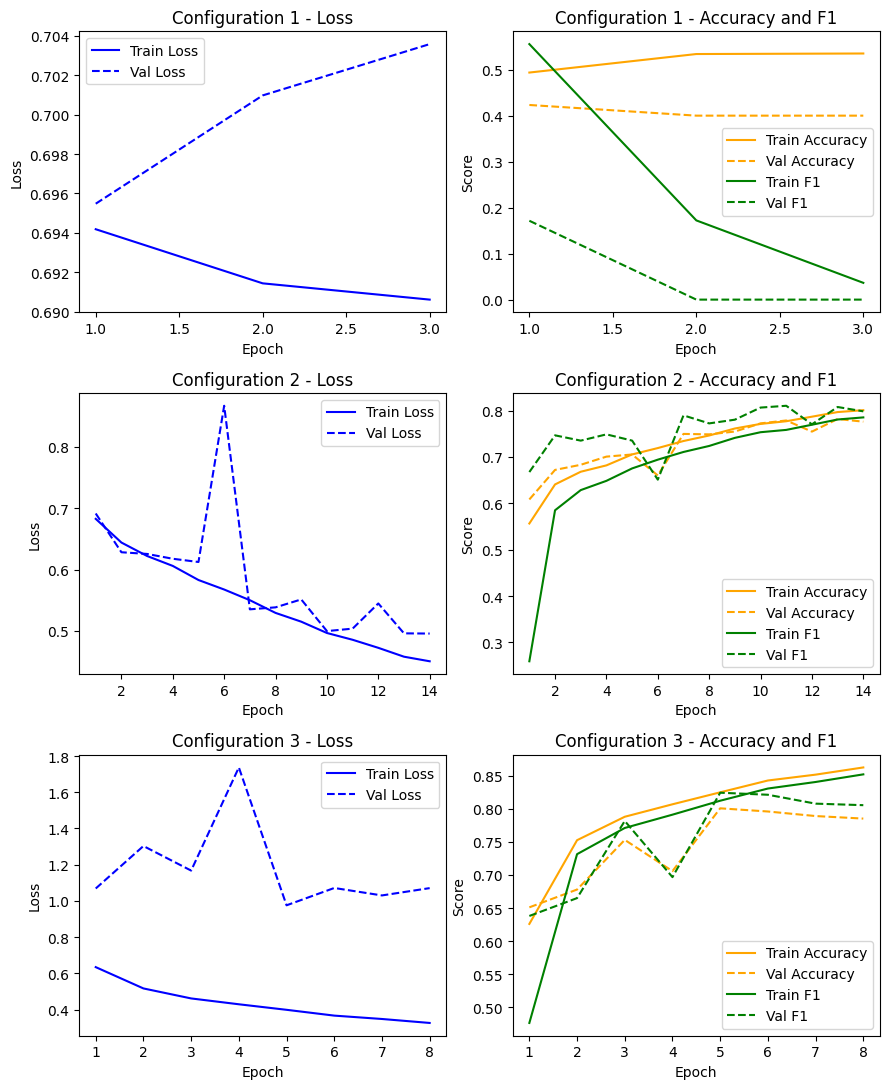

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(9, 11))


colors = {
    "train_loss": "blue",
    "val_loss": "blue",
    "train_acc": "orange",
    "val_acc": "orange",
    "train_f1": "green",
    "val_f1": "green",
}

line_styles = {"train": "-", "val": "--"}

# loop through each configuration
for i, config_id in enumerate([1, 2, 3]):
    config_df = df[df["config"] == config_id]
    # plot Loss Progression (left plot)
    ax[i, 0].plot(
        config_df["epoch"],
        config_df["train_loss"],
        color=colors["train_loss"],
        linestyle=line_styles["train"],
        label="Train Loss",
    )
    ax[i, 0].plot(
        config_df["epoch"],
        config_df["val_loss"],
        color=colors["val_loss"],
        linestyle=line_styles["val"],
        label="Val Loss",
    )
    ax[i, 0].set_title(f"Configuration {config_id} - Loss")
    ax[i, 0].set_xlabel("Epoch")
    ax[i, 0].set_ylabel("Loss")
    ax[i, 0].legend()

    # plot Accuracy and F1 Progression (right plot)
    ax[i, 1].plot(
        config_df["epoch"],
        config_df["train_acc"],
        color=colors["train_acc"],
        linestyle=line_styles["train"],
        label="Train Accuracy",
    )
    ax[i, 1].plot(
        config_df["epoch"],
        config_df["val_acc"],
        color=colors["val_acc"],
        linestyle=line_styles["val"],
        label="Val Accuracy",
    )
    ax[i, 1].plot(
        config_df["epoch"],
        config_df["train_f1"],
        color=colors["train_f1"],
        linestyle=line_styles["train"],
        label="Train F1",
    )
    ax[i, 1].plot(
        config_df["epoch"],
        config_df["val_f1"],
        color=colors["val_f1"],
        linestyle=line_styles["val"],
        label="Val F1",
    )
    ax[i, 1].set_title(f"Configuration {config_id} - Accuracy and F1")
    ax[i, 1].set_xlabel("Epoch")
    ax[i, 1].set_ylabel("Score")
    ax[i, 1].legend()

plt.tight_layout()
plt.show()

### Final Evaluation on the Test Set

After identifying the best-performing configuration during validation, we now instantiate the corresponding model, load its saved parameters, and evaluate its performance on the test set.

In [ ]:
# evaluate on test set
model = configs["config3"]


# Reinitialize the best model with Configuration 3 parameters
best_model = BiLSTM(**model)
best_model.load_state_dict(torch.load("best_model.pt"))  # Load saved parameters
best_model.to(device)

# Set model to evaluation mode and disable gradient calculation
best_model.eval()
with torch.no_grad():
    test_loss, test_acc, test_f1 = process(
        best_model, test_loader, nn.BCEWithLogitsLoss()
    )

# Print test results
print(
    f"\nTest Results: Loss = {test_loss:.4f}, Accuracy = {test_acc:.4f}, F1 Score = {test_f1:.4f}"
)

Evaluating:   0%|          | 0/782 [00:00<?, ?batches/s]

<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
<ipython-input-12-695c2b96817b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]


Evaluating: 100%|██████████| 782/782 [00:10<00:00, 75.74batches/s]
Unique values in predictions: (array([0, 1]), array([13380, 11620]))
Unique values in labels: (array([0., 1.], dtype=float32), array([12500, 12500]))

Test Results: Loss = 0.8169, Accuracy = 0.8137, F1 Score = 0.8069


We evaluated the model on the test set using the best hyperparameter configuration, which was found to be the third:


"config3" = "vocab_size": VOCAB_SIZE, "embedding_dim": 300,"hidden_size": 256, "rnn_size": 256, "dropout": 0.5


As can be seen from the evaluation on the test score, the model achieved a loss of 0.8169, an accuracy of 0.8137, and an F1 score of 0.8069

Which denotes a good ability of the model to generalize on unseen data. Specifically, the accuracy is good and the F1 score suggests a good balance between precision and recall but could still be improved.

The overall performance suggests that there are possibilities for improvement.

Even looking at the training and validation error/accuracy plot of the model with the third (best) configuration, we can make some important considerations.
In particular looking at the left graph ( Loss - epochs) we can see that from epoch 5 despite a consistent decrease in training loss the validation loss remains more or less stable and starts to increase slightly denoting a possible overfitting problem. This might suggest the adoption of regularization techniques.

This phenomenon is also denoted in the right plot which analyze the training and validation accuracy and F1 score.
From the fifth epoch, the train accuracy continues to increase while the validation accuracy slowly decrease.

 This might suggest that it would be interesting to test an early stopping in these epochs so as to avoid overfitting (we might think of decreasing the NUM_EPOCHS parameter by testing new values)

Possible improvements/considerations:

- Hyperparameter tuning, one could experiment with new hyperparameter configurations for example by implementing algorithms such as grid search ,random search or Bayesian optimization models. In doing so, however, we must take into account the cost of such computations, which for a model of this size can become very high.


- Regularization, adjusting dropout or applying L2 regularization could help the model generalize better. In particular we could try to increase the Dropout Rate to introduce more regularization.


Looking at the setting of the hyperparameters in the third cell:

VOCAB_SIZE = 20_000,
BATCH_SIZE = 32,
NUM_EPOCHS = 15,
MAX_LEN = 256,
LEARNING_RATE = 1e-4

To avoid the problem of overfitting we could try to reduce the batch_size that can introduce more noise in the gradient calculations, which may improve generalization. The downside is that training may take longer, but it can help the model generalize better to unseen data.

Then to adress the same problem, we can try to work on reducing MAX_LEN to 128 or 100. This will limit the input to only the most relevant words, which could reduce the noise and make the model more focused on key parts of the input potentially avoiding overfitting.

To conclude, the model achieved good results but leaves room for improvement, particularly in addressing the slight overfitting observed. Based on the considerations discussed, applying further regularization techniques and tuning specific hyperparameters, such as batch size, dropout, and learning rate, could enhance the model's generalization. These adjustments may help the model maintain or even improve its performance on unseen data while avoiding overfitting.







